<a href="https://colab.research.google.com/github/Eric-Chung-0511/Learning-Record/blob/main/Data%20Science%20Projects/SkimLit/SkimLit_Project_RoBERTa_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct


Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 68.58 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
# start the experiment usign 20K dataset with numbers replace by '@' sign
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
# check all of the filenames in the target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

In [ ]:
# create function to read in all of the lines of target text file
def get_lines(filename):
  '''
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
      filename: a string containing the target filepath
  Returns:
      a list of strings with one string per line from the target filename.
      '''
  with open(filename, 'r') as f:
    return f.readlines()

In [ ]:
# read the training lines
train_lines = get_lines(data_dir + 'train.txt')
train_lines[:30]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

## turn into certain format

* turn to dictionary
```
[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'Emotional eating is associated with overeating and the development of obesity .\n'
  'total_lines': 11},
  ...]

```

In [ ]:
# write a function to turn each datasets into the above format
def preprocess_text_with_line_numbers(filename):
  '''
  return a list of dictionary of abstract line data.
  Take in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number the target line is.
  '''
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = '' # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  for line in input_lines:
    if line.startswith('###'): # check if it is ID line
      abstract_id = line
      abstract_lines = ''  # reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see if the line is new line(\n)
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # Create an empty dictionary for each line
        target_text_split = abstract_line.split('\t') # split target label from text
        line_data['target'] = target_text_split[0] # get the label
        line_data['text'] = target_text_split[1].lower() # get the text
        line_data['line_number'] = abstract_line_number # what number line does the line appear in the abstract?
        line_data['total_lines'] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract (start from 0)
        abstract_samples.append(line_data)

    else: # if the above conditions are not fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
# Get data from file and preprocess
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt') # It's another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [ ]:
# check the first dataset of training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df  =pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

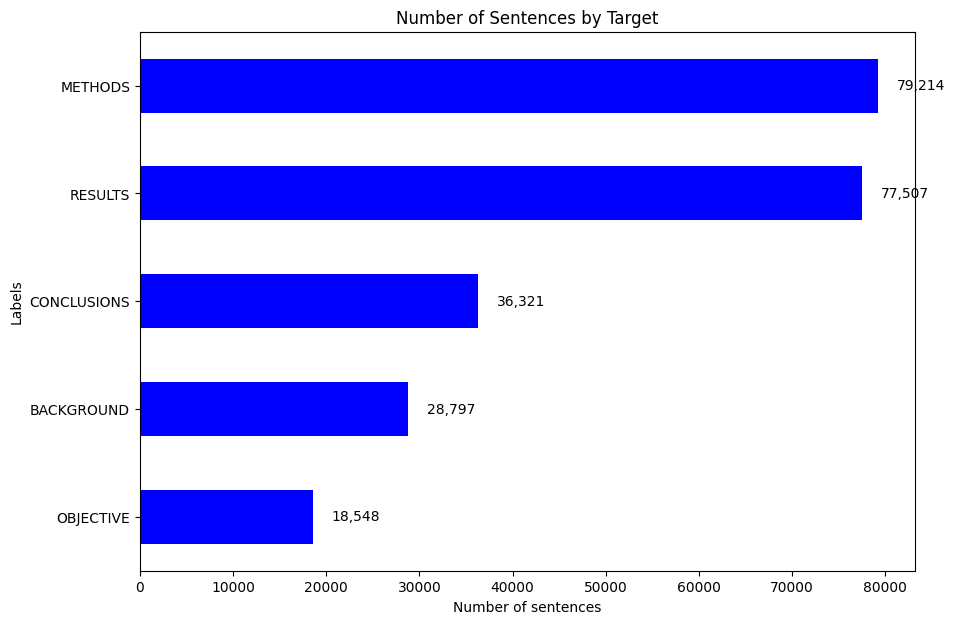

In [ ]:
# get whole data distribution
import matplotlib.pyplot as plt
train_targets = train_df['target'].value_counts()
val_targets = val_df['target'].value_counts()
test_targets = test_df['target'].value_counts()

targets_df = pd.DataFrame({'train': train_targets, 'val': val_targets, 'test': test_targets})

total_counts = targets_df.sum(axis=1)

fig, ax = plt.subplots(figsize=(10, 7))

total_counts.sort_values().plot(kind='barh', color='blue', ax=ax)

ax.set_title('Number of Sentences by Target')
ax.set_xlabel('Number of sentences')
ax.set_ylabel('Labels')

for i in ax.patches:
    ax.text(i.get_width() + 2000,
            i.get_y() + i.get_height() / 2,
            f'{int(i.get_width()):,}',
            ha='left',
            va='center',
            color='black')

plt.show()

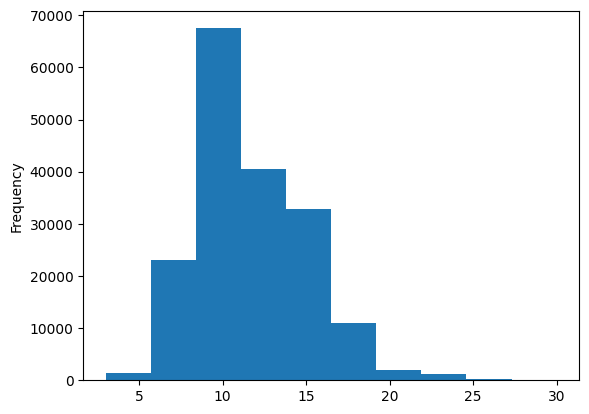

In [ ]:
train_df.total_lines.plot.hist();

In [ ]:
# use helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-06-23 11:51:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-23 11:51:11 (122 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
# Find out how many line numbers
train_df['line_number'].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

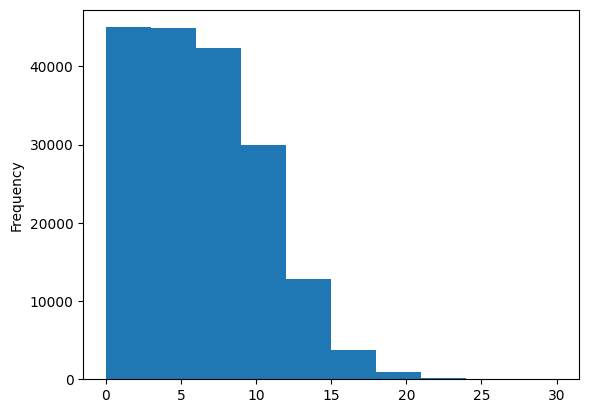

In [ ]:
# check the distribution of line numbers
train_df['line_number'].plot.hist();

In [ ]:
train_df['total_lines'].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

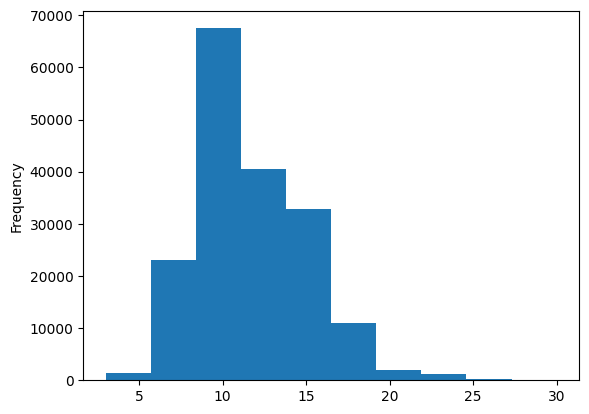

In [ ]:
train_df['total_lines'].plot.hist();

In [ ]:
# Check the coverage of a "total_lines" value of 20, value 20 cover 98%
np.percentile(train_df['total_lines'], 98)

20.0

In [ ]:
import re
import string
from helper_functions import calculate_results
from transformers import TFRobertaForSequenceClassification, TFRobertaModel, RobertaTokenizer
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Bidirectional, LSTM, Embedding
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder

In [ ]:
train_df = pd.DataFrame(train_samples)
val_df  =pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
# Encode Labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

In [ ]:
# Initialize tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Function to tokenize and pad sentences
def tokenize_sentences(sentences, max_length=512):
  return tokenizer(sentences, padding='max_length', max_length=max_length, truncation=True, return_tensors='tf')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
# Convert text to list and
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

# Tokenize sentences
train_encodings = tokenize_sentences(train_sentences)
val_encodings = tokenize_sentences(val_sentences)
test_encodings = tokenize_sentences(test_sentences)

In [ ]:
# One hot encoding to line number and total lines
train_line_number_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_number_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_number_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

print(train_encodings.keys())
print(train_encodings['input_ids'][0])
print(train_encodings['attention_mask'][0])

dict_keys(['input_ids', 'attention_mask'])
tf.Tensor(
[    0   560  4830     5 22081     9   787   688     9  1230   614    12
 35238 11651 12574 10892  1168  1264    11  3927  2400  2156 11525  2156
     8 18029   614    12  8425 16000    11     5   765  1385     8   549
     5  1683    74    28  5232    23   787   688    11  2530  3362    19
  7212     7  3814  4117 30311   139 16880 37830    36  1021   102  4839
   479     2     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1    

In [ ]:
#from tensorflow.keras.mixed_precision import set_global_policy

# set_global_policy('mixed_float16')

In [ ]:
# Setting TPU Strategy
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope():
    # Define Input Layer
    input_ids = Input(shape=(512,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(512,), dtype=tf.int32, name='attention_mask')
    line_number = Input(shape=(15,), dtype=tf.int32, name='line_number')
    total_lines = Input(shape=(20,), dtype=tf.int32, name='total_lines')

    # load pre-trained Roberta modek for classification
    roberta_model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_encoder.classes_))

    # Get RoBERTa model output
    roberta_outputs = roberta_model(input_ids, attention_mask=attention_mask)
    logits = roberta_outputs.logits

    # set line_number and total lines to float to keep it the same format
    line_number = tf.cast(line_number, tf.float32)
    total_lines = tf.cast(total_lines, tf.float32)

    # combine all features
    x = Concatenate()([logits, line_number, total_lines])

    # Add dense and output layers
    x = Dense(512, activation='gelu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='gelu')(x)
    x = Dropout(0.5)(x)
    output = Dense(len(label_encoder.classes_), activation='softmax')(x)

    # define Model
    bert_model = tf.keras.Model(inputs=[input_ids, attention_mask, line_number, total_lines], outputs=output)

    # learning_rate: Controls how much to update the model's weights at each step. A smaller learning rate
    # means the model's weights will be updated more slowly.
    # beta_1: The exponential decay rate for the first moment estimates.
    # beta_2: The exponential decay rate for the second moment estimates.
    # epsilon: A small constant for numerical stability to prevent any division by zero in the implementation.
    bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, beta_1=0.9, beta_2=0.98, epsilon=1e-6),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    bert_model.summary()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_for_sequence_cl  TFSequenceClassifierOutput   1246494   ['input_ids[0][0]',           
 assification (TFRobertaFor  (loss=None, logits=(None,    77         'attention_mask[0][0]']      
 SequenceClassification)     5),                                                              

In [ ]:
# Create tensorflow data set to train faster
train_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'input_1': train_line_number_one_hot,
    'input_2': train_total_lines_one_hot
}, train_labels_encoded)).cache().batch(256).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'input_1': val_line_number_one_hot,
    'input_2': val_total_lines_one_hot
}, val_labels_encoded)).cache().batch(256).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'input_1': test_line_number_one_hot,
    'input_2': test_total_lines_one_hot
}, test_labels_encoded)).cache().batch(256).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Callback for early stopping: monitors validation loss, stops training if no improvement after 3 epochs,
# and restores model weights from the epoch with the best validation loss.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Callback for learning rate reduction: monitors validation loss, reduces learning rate by a factor of 0.1
# if no improvement is observed for 2 consecutive epochs.
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

# Callback for model checkpointing: saves the model weights to the file 'RoBerta_model_01.h5'
# only if the validation loss improves. The mode 'min' ensures that it looks for a minimum validation loss.
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

bert_history = bert_model.fit(train_dataset,validation_data=val_dataset,epochs=20,callbacks=[early_stopping, lr_scheduler, checkpoint])

Epoch 1/20
704/704 [==============================] - ETA: 0s - loss: 0.5703 - accuracy: 0.7942

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


704/704 [==============================] - 885s 1s/step - loss: 0.5703 - accuracy: 0.7942 - val_loss: 0.3505 - val_accuracy: 0.8732 - lr: 3.0000e-05
Epoch 2/20
704/704 [==============================] - 705s 1s/step - loss: 0.3698 - accuracy: 0.8700 - val_loss: 0.3307 - val_accuracy: 0.8806 - lr: 3.0000e-05
Epoch 3/20
704/704 [==============================] - 705s 1s/step - loss: 0.3244 - accuracy: 0.8850 - val_loss: 0.3230 - val_accuracy: 0.8842 - lr: 3.0000e-05
Epoch 4/20
704/704 [==============================] - 705s 1s/step - loss: 0.2903 - accuracy: 0.8966 - val_loss: 0.3217 - val_accuracy: 0.8854 - lr: 3.0000e-05
Epoch 5/20
704/704 [==============================] - 699s 994ms/step - loss: 0.2610 - accuracy: 0.9066 - val_loss: 0.3497 - val_accuracy: 0.8815 - lr: 3.0000e-05
Epoch 6/20
704/704 [==============================] - 699s 993ms/step - loss: 0.2361 - accuracy: 0.9150 - val_loss: 0.3407 - val_accuracy: 0.8849 - lr: 3.0000e-05
Epoch 7/20
704/704 [=========================

In [ ]:
bert_pred_probs = bert_model.predict(val_dataset)
bert_preds = tf.argmax(bert_pred_probs, axis=1)

119/119 [==============================] - 57s 323ms/step


In [ ]:
bert_results = calculate_results(val_labels_encoded, bert_preds)

rounded_results = {
    "accuracy": f"{round(bert_results['accuracy'],2)}%",
    "precision": f"{round(bert_results['precision'] * 100, 2)}%",
    "recall": f"{round(bert_results['recall'] * 100, 2)}%",
    "f1": f"{round(bert_results['f1'] * 100, 2)}%"}

print(rounded_results)

{'accuracy': '88.54%', 'precision': '88.58%', 'recall': '88.54%', 'f1': '88.36%'}


### Save the model

In [ ]:
# h5 format
bert_model.save('RoBerta_model_02.h5')

In [ ]:
# SavedModel format
bert_model.save('saved_model/RoBerta_model_02')